In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import trange
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
data = pd.read_csv("signal_taus.csv")

## regression to eta-phi-coordinates

In [3]:
labels = data[['BsTauTau_tau_pt', 'BsTauTau_tau_eta', 'BsTauTau_tau_phi']]
data = data.drop(columns=['BsTauTau_tau_pt', 'BsTauTau_tau_eta', 'BsTauTau_tau_phi',
                          'Unnamed: 0', 'label_tau_px', 'label_tau_py','label_tau_pz', 'label_tau_abs' ])

In [4]:
indices = np.arange(len(data))
X_train, X_test, y_train, y_test, index_train, index_test = train_test_split(data, labels,indices, test_size=0.3, shuffle = True, random_state=42)

In [5]:
def train_on_cpu():  
    model = CatBoostRegressor(iterations=10000,  learning_rate=0.03,  objective="MultiRMSE")
    model.fit(X_train, y_train,   eval_set=(X_test, y_test),   verbose=1000 )
    return model

model = train_on_cpu()

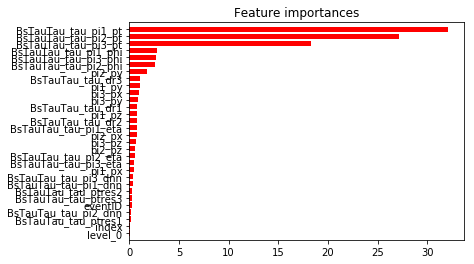

In [6]:
# Plot the feature importances 
importances = model.get_feature_importance()
index = np.argsort(importances)
importances = importances[index]
indices = list(data.columns)
indices = np.asarray(indices)[index]

plt.figure()
plt.rcParams['figure.figsize'] = [4, 7]
plt.title("Feature importances")
plt.barh(range(importances.shape[0]), importances, color="r", align="center")
plt.yticks(range(importances.shape[0]), indices)
plt.ylim([-1, importances.shape[0]])
plt.show()

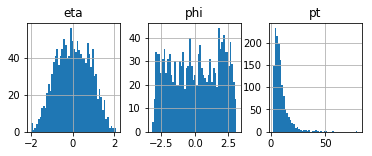

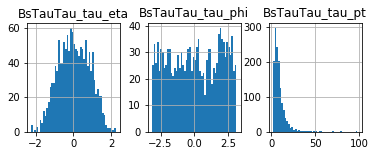

In [7]:
preds = model.predict(X_test)
preds_df = pd.DataFrame(columns=["pt","eta","phi"], data = preds)
preds_df.hist(bins = 50, layout = (1,3), figsize = (6,2) );
labels.iloc[index_test].hist(bins = 50, layout = (1,3), figsize = (6,2) );

In [8]:
# metric mse
mean_squared_error(labels.iloc[index_test], preds_df), r2_score(labels.iloc[index_test], preds_df)

(0.5934501339650421, 0.9741610505500559)

## regression to eta-phi-coordinates - features/target - scaled

In [ ]:
data = pd.read_csv("signal_taus.csv")
data = data.drop(columns = ["Unnamed: 0"])

In [ ]:
full_labels = data[['BsTauTau_tau_pt', 'BsTauTau_tau_eta', 'BsTauTau_tau_phi',
                         'label_tau_px', 'label_tau_py','label_tau_pz', 'label_tau_abs' ]]
target_labels = data[['BsTauTau_tau_pt', 'BsTauTau_tau_eta', 'BsTauTau_tau_phi']]
data = data.drop(columns=['BsTauTau_tau_pt', 'BsTauTau_tau_eta', 'BsTauTau_tau_phi',
                         'label_tau_px', 'label_tau_py','label_tau_pz', 'label_tau_abs' ])

In [ ]:
def scale_features_target(data,target_labels):
    scaler_features = StandardScaler()
    scaler_features.fit(data.values)
    data = pd.DataFrame(scaler_features.transform(data.values), columns=data.columns, index=data.index)
    
    scaler_targets = StandardScaler()
    scaler_targets.fit(target_labels)
    target_labels = pd.DataFrame(scaler_targets.transform(target_labels.values), columns=target_labels.columns, index=target_labels.index)    
    return data, target_labels, scaler_features, scaler_targets
data, target_labels, scaler_features, scaler_targets = scale_features_target(data,target_labels)

In [ ]:
indices = np.arange(len(data))
X_train, X_test, y_train, y_test, index_train, index_test = train_test_split(data, target_labels,indices, test_size=0.3, shuffle = True, random_state=42)

In [ ]:
def train_on_cpu():  
    model = CatBoostRegressor(iterations=20000,  learning_rate=0.03 ,  objective="MultiRMSE")
    model.fit(X_train, y_train,   eval_set=(X_test, y_test),   verbose=5000 )
    return model

model = train_on_cpu()

In [ ]:
preds = model.predict(X_test)
#descale
preds_descaled = scaler_targets.inverse_transform(preds)
preds_df = pd.DataFrame(columns=["pred pt","pred eta","pred phi"], data = preds_descaled)
preds_df.hist(bins = 50, layout = (1,3), figsize = (6,2) );
full_labels.iloc[index_test,:3].hist(bins = 50, layout = (1,3), figsize = (6,2) );

In [ ]:
# Plot the feature importances 
importances = model.get_feature_importance()
index = np.argsort(importances)
importances = importances[index]
indices = list(data.columns)
indices = np.asarray(indices)[index]

plt.figure()
plt.rcParams['figure.figsize'] = [4, 7]
plt.title("Feature importances")
plt.barh(range(importances.shape[0]), importances, color="r", align="center")
plt.yticks(range(importances.shape[0]), indices)
plt.ylim([-1, importances.shape[0]])
plt.show()

In [ ]:
# scaled
mean_squared_error(target_labels.iloc[index_test], preds), r2_score(target_labels.iloc[index_test], preds)

In [ ]:
# descaled
mean_squared_error(full_labels.iloc[index_test,:3], preds_df),  r2_score(full_labels.iloc[index_test,:3], preds_df)

In [ ]:
preds_df.columns

In [ ]:
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
plt.rcParams['figure.figsize'] = [14, 3]
ax1.hist(preds_df.iloc[:,0], density= True, alpha = 0.4, label="pred_pt")
ax1.hist(full_labels.iloc[index_test,0], density= True, alpha = 0.4, label="pt");
ax1.legend();

ax2.hist(preds_df.iloc[:,1], density= True, alpha = 0.4, label="pred_eta")
ax2.hist(full_labels.iloc[index_test,1], density= True, alpha = 0.4, label="eta");
ax2.legend();

ax3.hist(preds_df.iloc[:,2], density= True, alpha = 0.4, label="pred_phi")
ax3.hist(full_labels.iloc[index_test,2], density= True, alpha = 0.4, label="phi");
ax3.legend();

## regression to cartesian-coordinates - features/target - not scaled

In [ ]:
data = pd.read_csv("signal_taus.csv")
data = data.drop(columns = ["Unnamed: 0"])

full_labels = data[['BsTauTau_tau_pt', 'BsTauTau_tau_eta', 'BsTauTau_tau_phi',
                         'label_tau_px', 'label_tau_py','label_tau_pz', 'label_tau_abs' ]]
target_labels = data[['label_tau_px', 'label_tau_py','label_tau_pz']]
data = data.drop(columns=['BsTauTau_tau_pt', 'BsTauTau_tau_eta', 'BsTauTau_tau_phi',
                         'label_tau_px', 'label_tau_py','label_tau_pz', 'label_tau_abs' ])

In [ ]:
indices = np.arange(len(data))
X_train, X_test, y_train, y_test, index_train, index_test = train_test_split(data, target_labels,indices, test_size=0.3, shuffle = True, random_state=42)

In [ ]:
def train_on_cpu():  
    model = CatBoostRegressor(iterations=20000,  learning_rate=0.03 ,  objective="MultiRMSE")
    model.fit(X_train, y_train,   eval_set=(X_test, y_test),   verbose=5000 )
    return model

model = train_on_cpu()

In [ ]:
preds = model.predict(X_test)
preds_df = pd.DataFrame(columns=["px","py","pz"], data = preds)
preds_df.hist(bins = 50, layout = (1,3), figsize = (6,2) );
y_test.hist(bins = 50, layout = (1,3), figsize = (6,2) );

In [ ]:
# mse in cartesian coordinates
mean_squared_error(y_test, preds_df),  r2_score(y_test, preds_df)

In [ ]:
# mse in eta-phi coordinates
def to_eta_phi(preds_df):
    # we need atan2 and not arctan
    preds_df.insert(0,"pred_tau_phi", np.arctan2(preds_df.py, preds_df.px))
    preds_df.insert(1, "pred_tau_pt", pd.eval(" preds_df.px/ cos(preds_df.pred_tau_phi) "))
    preds_df.insert(2, "pred_tau_eta", pd.eval(" arcsinh(preds_df.pz/ preds_df.pred_tau_pt) "))
    return preds_df

original_test = full_labels.loc[index_test,['BsTauTau_tau_pt', 'BsTauTau_tau_eta', 'BsTauTau_tau_phi']]
preds_eta_phi = to_eta_phi(preds_df)[["pred_tau_pt","pred_tau_eta","pred_tau_phi"]]
mean_squared_error(original_test, preds_eta_phi),  r2_score(original_test, preds_eta_phi)

## regression to cartesian-coordinates - features/target - scaled

In [ ]:
data = pd.read_csv("signal_taus.csv")
data = data.drop(columns = ["Unnamed: 0"])

full_labels = data[['BsTauTau_tau_pt', 'BsTauTau_tau_eta', 'BsTauTau_tau_phi',
                         'label_tau_px', 'label_tau_py','label_tau_pz', 'label_tau_abs' ]]
target_labels = data[['label_tau_px', 'label_tau_py','label_tau_pz']]
data = data.drop(columns=['BsTauTau_tau_pt', 'BsTauTau_tau_eta', 'BsTauTau_tau_phi',
                         'label_tau_px', 'label_tau_py','label_tau_pz', 'label_tau_abs' ])

In [ ]:
data, target_labels, scaler_features, scaler_targets = scale_features_target(data,target_labels)

In [ ]:
indices = np.arange(len(data))
X_train, X_test, y_train, y_test, index_train, index_test = train_test_split(data, target_labels,indices, test_size=0.3, shuffle = True, random_state=42)

In [ ]:
def train_on_cpu():  
    model = CatBoostRegressor(iterations=20000,  learning_rate=0.03 ,  objective="MultiRMSE")
    model.fit(X_train, y_train,   eval_set=(X_test, y_test),   verbose=5000 )
    return model

model = train_on_cpu()

In [ ]:
preds = model.predict(X_test)
#descale
preds_descaled = scaler_targets.inverse_transform(preds)
preds_df = pd.DataFrame(columns=["px","py","pz"], data = preds_descaled)
preds_df.hist(bins = 50, layout = (1,3), figsize = (6,2) );
full_labels.loc[index_test,["label_tau_px","label_tau_py","label_tau_pz"]].hist(bins = 50, layout = (1,3), figsize = (6,2) );

In [ ]:
# Plot the feature importances 
importances = model.get_feature_importance()
index = np.argsort(importances)
importances = importances[index]
indices = list(data.columns)
indices = np.asarray(indices)[index]

plt.figure()
plt.rcParams['figure.figsize'] = [4, 7]
plt.title("Feature importances")
plt.barh(range(importances.shape[0]), importances, color="r", align="center")
plt.yticks(range(importances.shape[0]), indices)
plt.ylim([-1, importances.shape[0]])
plt.show()

In [ ]:
original_test = full_labels.loc[index_test,['BsTauTau_tau_pt', 'BsTauTau_tau_eta', 'BsTauTau_tau_phi']]
def to_eta_phi(preds_df):
    # we need atan2 and not arctan
    preds_df.insert(0,"pred_tau_phi", np.arctan2(preds_df.py, preds_df.px))
    preds_df.insert(1, "pred_tau_pt", pd.eval(" preds_df.px/ cos(preds_df.pred_tau_phi) "))
    preds_df.insert(2, "pred_tau_eta", pd.eval(" arcsinh(preds_df.pz/ preds_df.pred_tau_pt) "))
    return preds_df
preds_eta_phi = to_eta_phi(preds_df)[["pred_tau_pt","pred_tau_eta","pred_tau_phi"]]
mean_squared_error(original_test, preds_eta_phi),  r2_score(original_test, preds_eta_phi)

In [ ]:
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
plt.rcParams['figure.figsize'] = [14, 3]
ax1.hist(preds_eta_phi.iloc[:,0], density= True, alpha = 0.4, label="pred_pt")
ax1.hist(original_test.iloc[:,0], density= True, alpha = 0.4, label="pt");
ax1.legend();

ax2.hist(preds_eta_phi.iloc[:,1], density= True, alpha = 0.4, label="pred_eta")
ax2.hist(original_test.iloc[:,1], density= True, alpha = 0.4, label="eta");
ax2.legend();

ax3.hist(preds_eta_phi.iloc[:,2], density= True, alpha = 0.4, label="pred_phi")
ax3.hist(original_test.iloc[:,2], density= True, alpha = 0.4, label="phi");
ax3.legend();